In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

# I. Looking through and cleaning the data.

## Part 1: Understanding the data.

In [2]:
# Reading 'Life Expectancy Data.csv' into a DataFrame
path_to_file = '/Users/moatb/Desktop/M/Datasets/Life Expectancy Data.csv'
life_expectancy_df = pd.read_csv(path_to_file)
life_expectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# A short summary of the DataFrame
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
# Checking the possible values that 'Status' can have
life_expectancy_df['Status'].unique()

array(['Developing', 'Developed'], dtype=object)

In [5]:
# Checking for missing values
life_expectancy_df.isna().sum().sort_values(ascending=False)

Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
 thinness 5-9 years                 34
 thinness  1-19 years               34
 BMI                                34
Polio                               19
Diphtheria                          19
Life expectancy                     10
Adult Mortality                     10
 HIV/AIDS                            0
Country                              0
Year                                 0
Measles                              0
percentage expenditure               0
infant deaths                        0
Status                               0
under-five deaths                    0
dtype: int64

In [6]:
# Removing the extra white spaces
life_expectancy_df.columns = life_expectancy_df.columns.str.strip()

# Dropping the rows that are missing life expectancy
life_expectancy_df.dropna(axis=0, subset=['Life expectancy'], inplace=True)

# Turning 'Status' column into a dummy variable.
life_expectancy_df = pd.get_dummies(data=life_expectancy_df, columns=['Status'], drop_first=True)

To make the data a bit neater while looking through it, I reformatted the column names to get rid of the unnecessary white spaces.

I removed the rows that were missing life expectancy as well in order to keep the analysis of the data consistent with the regressions that will be performed, which will not be able to utilize the rows that are missing life expectancy (since it is the target variable).

I also noted that all of the columns have data types of float or int except 'Country' and 'Status'. Since 'Status' has two possible values ['Developing', 'Developed'], it is more meaningful to convert it into a dummy variable. 

In [7]:
# Looking at the correlation between 'Life expectancy' and all the columns in the DataFrame
life_expectancy_df.corrwith(life_expectancy_df['Life expectancy']).abs().sort_values(ascending=False)

Life expectancy                    1.000000
Schooling                          0.751975
Income composition of resources    0.724776
Adult Mortality                    0.696359
BMI                                0.567694
HIV/AIDS                           0.556556
Status_Developing                  0.482136
Diphtheria                         0.479495
thinness  1-19 years               0.477183
thinness 5-9 years                 0.471584
Polio                              0.465556
GDP                                0.461455
Alcohol                            0.404877
percentage expenditure             0.381864
Hepatitis B                        0.256762
under-five deaths                  0.222529
Total expenditure                  0.218086
infant deaths                      0.196557
Year                               0.170033
Measles                            0.157586
Population                         0.021538
dtype: float64

Based on the correlations to 'Life expectancy', it would seem that the top regressors are 'Schooling', 'Income composition of resources', 'Adult Mortality', 'BMI', 'HIV/AIDS', and 'Status_Developing'. It also seems that 'Population' is not a good regressor for 'Life expectancy'.

In [8]:
# Comparing the number of missing values in Developed countries (0) vs Developing countries (1)
life_expectancy_df.groupby('Status_Developing').agg(lambda x: x.isna().sum()).T.sort_values(ascending=False, by=[1, 0])

Status_Developing,0,1
Population,96,548
Hepatitis B,173,380
GDP,64,379
Total expenditure,32,194
Alcohol,28,165
Income composition of resources,48,112
Schooling,48,112
BMI,0,32
thinness 1-19 years,0,32
thinness 5-9 years,0,32


Note: A lot of the missing values in each column are from rows of developing countries rather than developed countries.

In [9]:
# Ensuring that all countries have 16 years of data
life_expectancy_df.groupby('Country').filter(lambda x: x['Year'].count() < 16) # empty dataset

,Country,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing


## Part 2: Visualizing the data.

The densities of the top possible regressors provide an overview of the columns' data. Plotting them will display if the regressors of interest are skewed or have outliers.

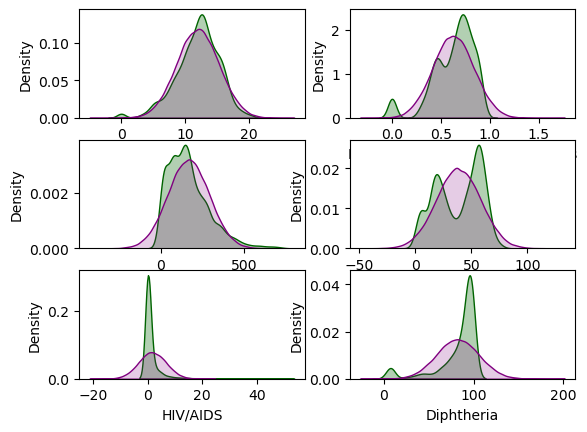

In [10]:
fig, ax = plt.subplots(3, 2)
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.autolayout"] = True

feature = 'Schooling'
ave = life_expectancy_df[feature].mean()
sd = life_expectancy_df[feature].std()
sns.kdeplot(data=life_expectancy_df, x=feature, fill=True, alpha=0.3, legend=True, color='darkgreen', ax=ax[0,0]);
sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[0,0]);

feature = 'Income composition of resources'
ave = life_expectancy_df[feature].mean()
sd = life_expectancy_df[feature].std()
sns.kdeplot(data=life_expectancy_df, x=feature, fill=True, alpha=0.3, legend=True, color='darkgreen', ax=ax[0,1]);
sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[0,1]);

feature = 'Adult Mortality'
ave = life_expectancy_df[feature].mean()
sd = life_expectancy_df[feature].std()
sns.kdeplot(data=life_expectancy_df, x=feature, fill=True, alpha=0.3, legend=True, color='darkgreen', ax=ax[1,0]);
sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[1,0]);

feature = 'BMI'
ave = life_expectancy_df[feature].mean()
sd = life_expectancy_df[feature].std()
sns.kdeplot(data=life_expectancy_df, x=feature, fill=True, alpha=0.3, legend=True, color='darkgreen', ax=ax[1,1]);
sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[1,1]);

feature = 'HIV/AIDS'
ave = life_expectancy_df[feature].mean()
sd = life_expectancy_df[feature].std()
sns.kdeplot(data=life_expectancy_df, x=feature, fill=True, alpha=0.3, legend=True, color='darkgreen', ax=ax[2,0]);
sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[2,0]);

feature = 'Diphtheria'
ave = life_expectancy_df[feature].mean()
sd = life_expectancy_df[feature].std()
sns.kdeplot(data=life_expectancy_df, x=feature, fill=True, alpha=0.3, legend=True, color='darkgreen', ax=ax[2,1]);
sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[2,1]);


Based on the density plots, 'Schooling' will be a good regressor to work with even though it is slightly skewed. The distribution of 'BMI' is bimodal, and 'Income composition of reources' also has multiple peaks, which may make these features a little difficult to work with in a simple linear regression model.

## Part 3: Putting all the data cleaning into one function.

In [11]:
def life_expectancy():
    
    path_to_file = '/Users/moatb/Desktop/M/Datasets/Life Expectancy Data.csv'
    life_expectancy_df = pd.read_csv(path_to_file)
    
    # Removing unnecessary white spaces
    life_expectancy_df.columns = life_expectancy_df.columns.str.strip().str.lower()
    # Renaming specific columns to be more concise
    life_expectancy_df.rename(columns={'percentage expenditure': 'per_expend',
                                       'hepatitis b': 'hep_b',
                                       'total expenditure': 'total_expend',
                                       'income composition of resources': 'icr',
                                       'hiv/aids': 'hiv_aids',
                                       'thinness 5-9 years': 'thin 5-9 years',
                                       'thinness  1-19 years': 'thin 1-19 years'}, inplace=True)
    # Reformatting column names
    life_expectancy_df.columns = life_expectancy_df.columns.str.replace(" ", "_", regex=False)
    
    # Removing rows that are missing life expectancy rows
    life_expectancy_df.dropna(axis=0, subset=['life_expectancy'], inplace=True)
    
    # Changing the 'country' column dtype to 'category'
    life_expectancy_df['country'] = life_expectancy_df['country'].astype('category')

    # Converting 'status' column into a dummy variable
    life_expectancy_df = pd.get_dummies(data=life_expectancy_df, columns=['status'], drop_first=True)
    life_expectancy_df.rename(columns={'status_Developing': 'status'}, inplace=True)

    # Getting rid of 'population' column
    life_expectancy_df.drop(columns=['population'], inplace=True)
    
    # Sorting by status (descending), country name (ascending), year (descending)
    life_expectancy_df = life_expectancy_df.sort_values(by=['status', 'country', 'year'], 
                                                        ascending=[False, True, False])
    
    return life_expectancy_df

preprocessed_df = life_expectancy()

I included all of the data cleaning that was done thus far under one function, and I also changed the data type of 'country' from object to category to signal to Python that it is a categorical variable. Additionally, I removed the 'population' column because it had the lowest correlation to life expectancy as well as having the most missing values out of all the columns.

In [12]:
preprocessed_df

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,per_expend,hep_b,measles,bmi,under-five_deaths,polio,total_expend,diphtheria,hiv_aids,gdp,thin_1-19_years,thin_5-9_years,icr,schooling,status
0,Afghanistan,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,17.2,17.3,0.479,10.1,1
1,Afghanistan,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,17.5,17.5,0.476,10.0,1
2,Afghanistan,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,17.7,17.7,0.470,9.9,1
3,Afghanistan,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,17.9,18.0,0.463,9.8,1
4,Afghanistan,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,18.2,18.2,0.454,9.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,United States of America,2004,77.5,111.0,28,8.48,0.000000,92.0,37,63.1,33,92.0,15.14,96.0,0.1,NaN,0.7,0.6,NaN,NaN,0
2806,United States of America,2003,77.2,114.0,28,8.40,0.000000,92.0,56,62.4,33,91.0,15.60,96.0,0.1,NaN,0.7,0.6,NaN,NaN,0
2807,United States of America,2002,77.0,115.0,28,8.33,0.000000,88.0,41,61.7,33,9.0,14.55,94.0,0.1,NaN,0.8,0.6,NaN,NaN,0
2808,United States of America,2001,76.9,115.0,28,8.25,0.000000,89.0,116,6.9,33,89.0,13.73,94.0,0.1,NaN,0.8,0.6,NaN,NaN,0


# II. Dealing with missing values.

As was seen previously, there are a lot of missing values...

In [13]:
preprocessed_df.isna().sum().sort_values(ascending=False)

hep_b                553
gdp                  443
total_expend         226
alcohol              193
schooling            160
icr                  160
thin_5-9_years        32
thin_1-19_years       32
bmi                   32
diphtheria            19
polio                 19
country                0
hiv_aids               0
under-five_deaths      0
year                   0
measles                0
per_expend             0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

To fill the missing values for the first two models, I will use the K-Nearest Neighborhood (KNN) algorithm.

In [14]:
# Creating a DataFrame of all the possible features that can be used in the regression
X = preprocessed_df.drop(columns=['country', 'life_expectancy'])

# Standardizing the features
scaler_model = StandardScaler()
scaler_model.fit(X)
X_rescaled = scaler_model.transform(X)

# Using KNN to impute missing values
knn_inputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
knn_inputer.fit(X_rescaled)
knn_inputer.transform(X_rescaled)

array([[ 1.62697843,  0.79023802,  0.26751977, ..., -0.70360648,
        -0.5677621 ,  0.46034827],
       [ 1.41004798,  0.85461353,  0.2844554 , ..., -0.71782854,
        -0.59765   ,  0.46034827],
       [ 1.19311752,  0.83047271,  0.30139102, ..., -0.74627265,
        -0.62753789,  0.46034827],
       ...,
       [-1.19311752, -0.40070899, -0.02038579, ..., -0.83539755,
        -0.37050197, -2.1722684 ],
       [-1.41004798, -0.40070899, -0.02038579, ...,  1.07794322,
         1.36299615, -2.1722684 ],
       [-1.62697843, -0.40875593, -0.02038579, ..., -0.88185627,
        -0.43027776, -2.1722684 ]])

Here, the KNN algorithm is looking at the five closest points to the point of interest (the missing value) in a 19-dimensional space (since X includes 19 columns) and imputing the null value using an equally weighted mean of the five closest points. I scaled the data since certain features have larger magnitudes than others, which would affect the calculation of the missing value if left unscaled.

Note: For the first two models, I set the parameter n_neighbors=5, but for the third model, I will adjust the parameter to account for outliers in the data.

In [15]:
# Unscaling the features that were scaled, aligning the index of the original DataFrame and columns of X
reshaped_data_df = pd.DataFrame(scaler_model.inverse_transform(knn_inputer.transform(X_rescaled)),
                                index=preprocessed_df.index,
                                columns=X.columns)
# Adding the 'country' column back in
reshaped_data_df['country'] = preprocessed_df['country']

In [16]:
reshaped_data_df.isna().sum()

year                 0
adult_mortality      0
infant_deaths        0
alcohol              0
per_expend           0
hep_b                0
measles              0
bmi                  0
under-five_deaths    0
polio                0
total_expend         0
diphtheria           0
hiv_aids             0
gdp                  0
thin_1-19_years      0
thin_5-9_years       0
icr                  0
schooling            0
status               0
country              0
dtype: int64

In [17]:
# Checking the correlation to life expectancy with the columns within reshaped_data_df
reshaped_data_df.corrwith(preprocessed_df['life_expectancy']).abs().sort_values(ascending=False)

schooling            0.758862
icr                  0.728610
adult_mortality      0.696359
bmi                  0.570888
hiv_aids             0.556556
status               0.482136
diphtheria           0.481965
thin_1-19_years      0.478790
thin_5-9_years       0.472869
polio                0.468690
gdp                  0.449950
alcohol              0.412482
per_expend           0.381864
hep_b                0.344283
total_expend         0.236241
under-five_deaths    0.222529
infant_deaths        0.196557
year                 0.170033
measles              0.157586
dtype: float64

# III. A simple linear regression model.

## Part 1: Training the model.

R^2: 0.5758710368267886
RMSE: 6.201377005474504


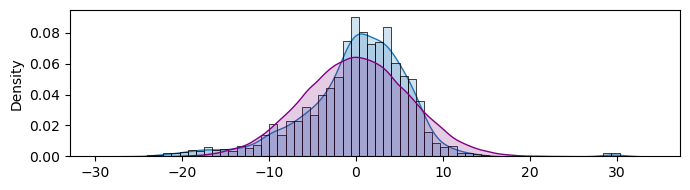

In [18]:
# Setting the feature and target of our model 
X = np.array(reshaped_data_df.loc[:, ['schooling']]) # feature
y = np.array(preprocessed_df.loc[:, ['life_expectancy']]) # target

# Using a linear regression model to predict life expectancy
lm_model = LinearRegression()
lm_model.fit(X=X, y=y)
y_pred = lm_model.predict(X=X)

# Calculating the residuals (true value - predicted value)
residuals = (y - y_pred)
RMSE = residuals.std() # Root Mean Square Error
r2 = lm_model.score(X=X, y=y) # coefficient of determination R^2
print(f"R^2: {r2}\nRMSE: {RMSE}")

# Plotting the distribution of the residuals
plt.rcParams["figure.figsize"] = [7, 2]
plt.rcParams["figure.autolayout"] = True
sns.kdeplot(x=(y - y_pred)[:, 0], fill=True, alpha=0.2);
sns.histplot(x=(y - y_pred)[:, 0], fill=True, alpha=0.2, stat='density');
sns.kdeplot(x=np.random.normal(scale=np.std((y - y_pred)[:, 0]), size=100000), fill=True, alpha=0.2, color='purple');

In the simple linear regression model, only one feature is used ('schooling') to predict our target ('life_expectancy'); the feature 'schooling' was chosen because it had the highest correlation to 'life_expectancy'. I fit the model using the defined feature and target, and created a np array 'y_pred' to contain the predicted 'life_expectancy' value of each row in X. 

After finding the predicted values, I calculated the residuals, root mean square error, and R squared value. These provide insight on model performance: we want the residuals to be normally distributed, the RMSE to be low, and the R squared to be close to 1. 

As seen above, the density plot of the residuals (blue) is close to a normal distribution (purple), but is slightly skewed to the left. The R squared value and RMSE are decent; R squared explains how much of the variation of 'life_expectancy' is explained by 'schooling', while the RMSE indicates the average error when predicting a value.

## Part 2: Running a k-fold cross validation.

A k-fold cross-validation will better evaluate the performance of the model as it divide the data into equal subsets and train the model with each subset. This process is repeated, and the results reflect what can be expected from the model.

In [19]:
# Defining the feature and target
X = preprocessed_df.drop(columns=['country', 'life_expectancy']).loc[:, ['schooling']]
y = preprocessed_df.loc[:, ['life_expectancy']]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=145)

# Setting the k-fold cross-validation parameters
cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=100)
splitting = cv.split(X=X_train, y=y_train)

RMSEs = []
train_r2_scores = []
test_r2_scores = []

for train_index, test_index in splitting:
    
    # Remormalizing the values in the subtraining dataset
    X_subtraining = X_train.iloc[train_index, :]
    scaler_model = StandardScaler()
    scaler_model.fit(X_subtraining)
    X_subtraining = scaler_model.transform(X_subtraining)
    
    # Using KNN to infer missing values
    knn_inputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    knn_inputer.fit(X_subtraining)
    X_subtraining = knn_inputer.transform(X_subtraining)
        
    # Transforming the values in the subtesting dataset
    X_subtesting = X_train.iloc[test_index, :]
    X_subtesting = scaler_model.transform(X_subtesting)
    X_subtesting = knn_inputer.transform(X_subtesting)
    
    # Building a linear regression model
    lm_model = LinearRegression()
    lm_model.fit(X=X_subtraining, y=y_train.iloc[train_index, :])
    y_true = y_train.iloc[test_index, :]
    y_pred = lm_model.predict(X_subtesting)
    
    # Finding R squared values and RMSE
    train_r2_score = lm_model.score(X=X_subtraining, y=y_train.iloc[train_index, :])
    test_r2_score = lm_model.score(X=X_subtesting, y=y_train.iloc[test_index, :])
    RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

    RMSEs.append(RMSE)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)
    
print(f"train_R^2: {np.mean(train_r2_scores)}\ntest_R^2: {np.mean(test_r2_scores)}\nRMSE: {np.mean(RMSEs)}")

train_R^2: 0.5311529654737087
test_R^2: 0.5280017776514347
RMSE: 6.536174975973251


The R squared values and RMSEs are slightly different than the values for the prior regression, but they are not too far off. These R squared and RMSE reflect what we can expect and are essentially the result of evaluating 500 models, since the nsplits=5 and n_repeats=100.

## Part 3: Evaluating the fitted model on a test set.

R^2: 0.5095888866360463
RMSE: 6.71344541341113


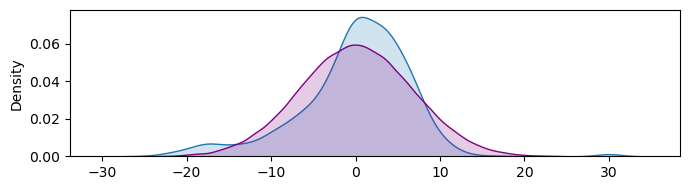

In [20]:
# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=145)

# Let's remormalize the values in the subtraining dataset
scaler_model = StandardScaler()
scaler_model.fit(X_train)
X_train = scaler_model.transform(X_train)

# Using KNN to impute missing values
knn_inputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
knn_inputer.fit(X_train)
X_train = knn_inputer.transform(X_train)

# Transforming the values in the testing dataset
X_test = scaler_model.transform(X_test)
X_test = knn_inputer.transform(X_test)

# Training the model
lm_model = LinearRegression()
lm_model.fit(X=X_train, y=y_train)
y_true = y_test
y_pred = lm_model.predict(X_test)

train_r2_score = lm_model.score(X=X_train, y=y_train)
test_r2_score = lm_model.score(X=X_test, y=y_test)
RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    
test_r2_score = lm_model.score(X=X_test, y=y_true)
RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

print(f"R^2: {test_r2_score}\nRMSE: {RMSE}")

residuals = y_true - y_pred
plt.rcParams["figure.figsize"] = [7, 2]
plt.rcParams["figure.autolayout"] = True
sns.kdeplot(data=residuals, color='yellow', fill=True, alpha=0.2, legend=False);
sns.kdeplot(x=np.random.normal(scale=RMSE, size=100000), fill=True, alpha=0.2, color='purple');

The R squared above is the test R squared score, which indicates how well the model performed on data that it has not seen while it was being trained. The R squared is close to the mean of the test R squared values from the cross validation, and the RMSE is slightly higher but is also close to the value from the cross validation.

# IV. A linear regression combining principal component analysis.

Principal Component Analysis will consolidate the features and will remedy the multicollinearity between certain regressors. Using a linear regression combining PCA should provide a model with better performance.

## Part 1: Examining correlations.

While looking through the data, I observed that the top possible regressors were: 'Schooling', 'Income composition of resources', 'Adult Mortality', 'BMI', 'HIV/AIDS', and 'Status_Developing'. I will select these features to include in the linear regression with PCA.

<AxesSubplot:>

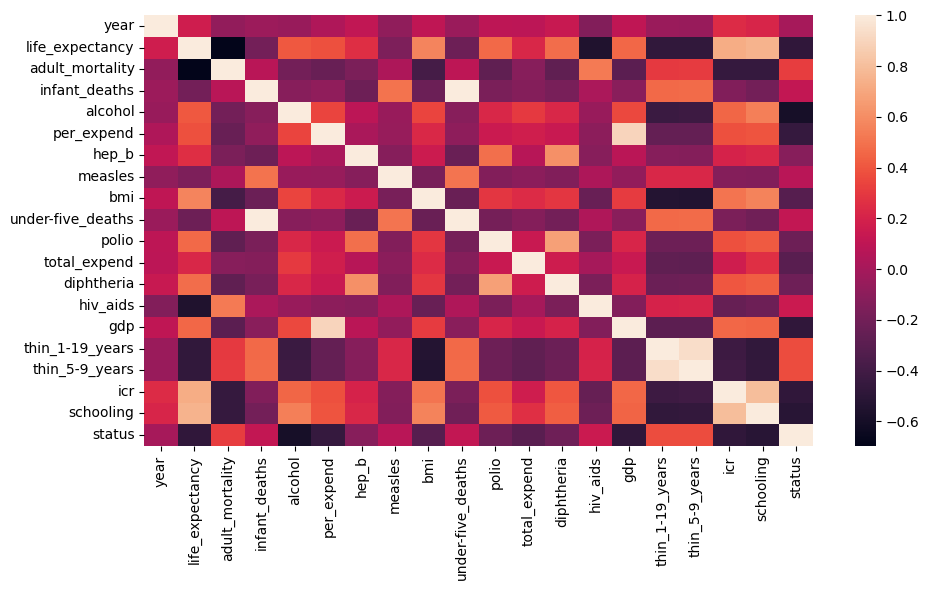

In [21]:
# Visualizing the correlation of the features with a heatmap
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(data=preprocessed_df.corr())
# sns.pairplot(data=preprocessed_df)

The heatmap above displays the correlation between regressors. In linear regression, it is assumed that the regressors are uncorrelated with one another. However, using PCA would enable the use of the correlated regressors since it would turn them into principal compnents, which would retain the most important information on the data.

In [22]:
# Looking at the correlation between the top regressors
regressors = ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']
preprocessed_df[regressors].corr()

,schooling,icr,adult_mortality,bmi,hiv_aids,status
schooling,1.000000,0.800046,-0.454612,0.558363,-0.222214,-0.515827
icr,0.800046,1.000000,-0.457626,0.509299,-0.249380,-0.478826
adult_mortality,-0.454612,-0.457626,1.000000,-0.387017,0.523821,0.315284
bmi,0.558363,0.509299,-0.387017,1.000000,-0.243735,-0.315092
hiv_aids,-0.222214,-0.249380,0.523821,-0.243735,1.000000,0.149178
status,-0.515827,-0.478826,0.315284,-0.315092,0.149178,1.000000


A better look at the correlation between the top regressors can be seen above.

## Part 2: Training the model.

Determining the principal components...

In [23]:
X = reshaped_data_df.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = preprocessed_df.loc[:, ['life_expectancy']]

pca_model = PCA()
pca_model.fit(X)
X = pca_model.transform(X)

In [24]:
# Displaying the correlation of the components with 'life_expectancy'
pd.DataFrame(X).corrwith(other=y['life_expectancy']).abs().sort_values(ascending=False)

0    0.122724
1    0.066892
5    0.066341
4    0.057482
2    0.031477
3    0.001235
dtype: float64

R^2: 0.8010820169982746 
RMSE: 4.24694065723372
[[ 0.85544285]
 [-3.95446895]
 [-3.84320214]
 ...
 [ 6.00284734]
 [-0.1475018 ]
 [ 8.7467921 ]]
(2928, 1)


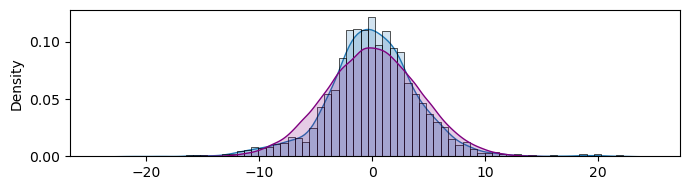

In [25]:
X = reshaped_data_df.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = np.array(preprocessed_df.loc[:, ['life_expectancy']])

pca_model = PCA()
pca_model.fit(X)
X = pca_model.transform(X)

selected_components = [0, 1, 5, 4, 2, 3]
lm_model = LinearRegression()
lm_model.fit(X[:, selected_components], y=y)
y_pred = lm_model.predict(X=X[:, selected_components])

# Calculating the residuals (actual value - predicted value)
residuals = (y - y_pred)
RMSE = residuals.std() # Root Mean Square Error
R2 = lm_model.score(X=X[:, selected_components], y=y) # coefficient of determination R^2
print('R^2:', R2, '\nRMSE:', RMSE)
print(residuals)
print(residuals.shape)

# Displaying the distribution of the residuals
plt.rcParams["figure.figsize"] = [7, 2]
plt.rcParams["figure.autolayout"] = True
sns.kdeplot(x=residuals[:, 0], fill=True, alpha=0.2);
sns.histplot(x=residuals[:, 0], fill=True, alpha=0.2, stat='density');
sns.kdeplot(x=np.random.normal(scale=np.std(residuals[:, 0]), size=100000), fill=True, alpha=0.2, color='purple');

The combined linear regression and PCA model has a much higher R squared value as well as a lower RMSE. More importantly, the residuals look closer to a normal distribution than the simple linear regression model.

## Part 3: Running a k-fold cross validation.

In [26]:
# Defining the features and target
X = reshaped_data_df.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = preprocessed_df.loc[:, ['life_expectancy']]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=145)

# Setting the k-fold cross-validation parameters
cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=100)
splitting = cv.split(X=X_train, y=y_train)

RMSEs = []
train_r2_scores = []
test_r2_scores = []

for train_index, test_index in splitting:
    
    X_subtraining = X_train.iloc[train_index, :].copy()
    X_subtesting = X_train.iloc[test_index, :].copy()
    
    # Using PCA for feature engineering
    pca_model = PCA()
    pca_model.fit(X_subtraining)
    X_subtraining = pca_model.transform(X_subtraining)

    # Transforming the values in the subtesting dataset
    X_subtesting = pca_model.transform(X_subtesting)
    
    selected_components = [0, 1, 5, 4, 2, 3]
    
    # Building a linear regression model
    lm_model = LinearRegression()
    lm_model.fit(X=X_subtraining[:, selected_components], y=np.array(y_train.iloc[train_index]))
    y_true = np.array(y_train.iloc[test_index, :])
    y_pred = lm_model.predict(X=X_subtesting[:, selected_components])
    
    # Finding R squared values and RMSE
    train_r2 = lm_model.score(X=X_subtraining[:, selected_components], y=np.array(y_train.iloc[train_index]['life_expectancy']))
    test_r2 = lm_model.score(X=X_subtesting[:, selected_components], y=y_true)
    RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    
    RMSEs.append(RMSE)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

print(f"train_R^2: {np.mean(train_r2_scores)}\ntest_R^2: {np.mean(test_r2_scores)}\nRMSE: {np.mean(RMSEs)}")

train_R^2: 0.8055477276657717
test_R^2: 0.8019873789169474
RMSE: 4.225350100613437


The cross validation of the linear regression and PCA model demonstrates that the higher R squared score and lower RMSE are expected with this model. These values show that utilizing PCA improved the model substantially.

## Part 4: Evaluating the fitted model on a test set.

R^2: 0.7955408555076536
RMSE: 4.3347951623953485


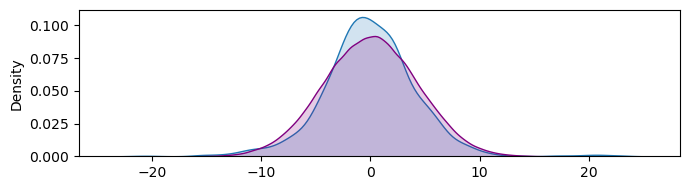

In [27]:
X = reshaped_data_df.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = preprocessed_df.loc[:, ['life_expectancy']]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=145)

# Fitting the PCA model
pca_model = PCA()
pca_model.fit(X_train)
X_train_reduced = pca_model.transform(X_train)

# Transforming the values in the test set
X_test_reduced = pca_model.transform(X_test)

selected_components = [0, 1, 5, 4, 2, 3]

# Building a linear regression model
lm_model = LinearRegression()
lm_model.fit(X=X_train_reduced[:, selected_components], y=np.array(y_train))
y_pred = lm_model.predict(X=X_test_reduced[:, selected_components])
y_true = np.array(y_test)

# Finding R squared values and RMSE
residuals = y_true - y_pred
train_r2_score = lm_model.score(X=X_train_reduced[:, selected_components], y=np.array(y_train))
test_r2_score = lm_model.score(X=X_test_reduced[:, selected_components], y=y_true)
RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

print(f"R^2: {test_r2_score}\nRMSE: {RMSE}")

plt.rcParams["figure.figsize"] = [7, 2]
plt.rcParams["figure.autolayout"] = True
sns.kdeplot(data=residuals, color='blue', fill=True, alpha=0.2, legend=False);
sns.kdeplot(x=np.random.normal(scale=RMSE, size=100000), fill=True, alpha=0.2, color='purple');

# V. A linear regression model that attempts to improve prediction accuracy.

As noted previously, several of the top regressors for 'life_expectancy' are highly correlated with one another. If I remove the correlated regressors, I would be able to avoid multicollinearity, but I would only be left with 'schooling' and 'adult_mortality' as regressors (which I tried and did not improve the prediction accuracy). To improve prediction accuracy, I would like to finetune the combined linear regression and PCA model as it addresses the multicollinearity issue and has improved the model substantially already.

To improve the linear regression + PCA model, I will start by refilling missing values to account for outliers.

## Part 1: Looking through the data once more.

In Section I, I looked through the missing values, but I noticed that there were also many 0 values for 'Income composition of resources' when looking at the distribution plots of the possible regressors. I will check for 0 values since a value of '0' can mean that data was not entered properly. 

In [28]:
# Checking how many 0 values are in each column
preprocessed_df.groupby('status').agg(lambda x: (x==0).sum()).T.sort_values(ascending=False, by=[1, 0])

status,0,1
measles,131,842
infant_deaths,321,517
per_expend,92,514
under-five_deaths,298,477
icr,0,130
schooling,0,26
country,0,0
year,0,0
life_expectancy,0,0
adult_mortality,0,0


In [29]:
preprocessed_df.drop(columns=['measles', 'infant_deaths'], inplace=True);

Based on the table above, I decided to drop 'measles' and 'infant_deaths' since they had the most amount of 0 values, which could be misentered data, and they were uncorrelated with 'life_expectancy' as well. 

I am also going to replace 0's in 'per_expend', 'icr', and 'schooling' with np.nan so that they can be estimated with the KNN imputer. There were many 0 values for 'icr' in developing countries, which may mean that they were misentered or missing; also, 'icr' and 'schooling' are highly correlated to 'life_expectancy' and are included in the principal component analysis.

In [30]:
preprocessed_df.loc[:, ['per_expend', 'icr', 'schooling']] =\
    preprocessed_df.loc[:, ['per_expend', 'icr', 'schooling']].apply(lambda x: np.where(x==0, np.nan, x))

In [31]:
preprocessed_df.groupby('status').agg(lambda x: (x==0).sum()).T.sort_values(ascending=False, by=[1, 0])

status,0,1
under-five_deaths,298,477
country,0,0
year,0,0
life_expectancy,0,0
adult_mortality,0,0
alcohol,0,0
per_expend,0,0
hep_b,0,0
bmi,0,0
polio,0,0


## Part 2: Refilling missing values

There are now more missing values overall...

In [32]:
preprocessed_df.isna().sum().sort_values(ascending=False)

per_expend           606
hep_b                553
gdp                  443
icr                  290
total_expend         226
alcohol              193
schooling            186
bmi                   32
thin_5-9_years        32
thin_1-19_years       32
polio                 19
diphtheria            19
country                0
hiv_aids               0
year                   0
under-five_deaths      0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

In [33]:
# Comparing the number of missing values in Developed countries (0) vs Developing countries (1)
preprocessed_df.groupby('status').agg(lambda x: x.isna().sum()).T.sort_values(ascending=False, by=[1, 0])

status,0,1
per_expend,92,514
hep_b,173,380
gdp,64,379
icr,48,242
total_expend,32,194
alcohol,28,165
schooling,48,138
bmi,0,32
thin_1-19_years,0,32
thin_5-9_years,0,32


In [34]:
developed = preprocessed_df.loc[preprocessed_df['status'] == 0, :]
developing = preprocessed_df.loc[preprocessed_df['status'] == 1, :]

In [35]:
print(developed.shape)
print(developing.shape)

(512, 19)
(2416, 19)


Since our PCA model combines the features ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status'], I will focus on these columns.

I also decided to separate the features by 'status' when looking for outliers, since there are more developing countries overall and there are more missing values for them for each column. It may help to impute the missing values separately for developing and developed countries, as the number of neighbors paremeters may need to be higher when imputing missing values for developing countries.

Of the six features, 'schooling', 'icr', and 'bmi' are the only ones with missing values, and I will plot boxplots of each to check for outliers...

<AxesSubplot:xlabel='schooling'>

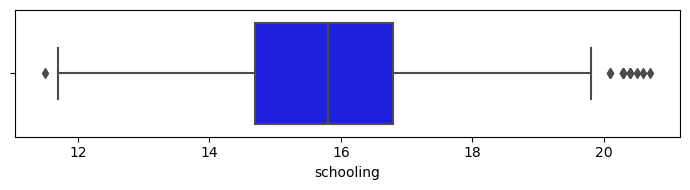

In [36]:
sns.boxplot(data=developed, x='schooling', color='blue')

<AxesSubplot:xlabel='schooling'>

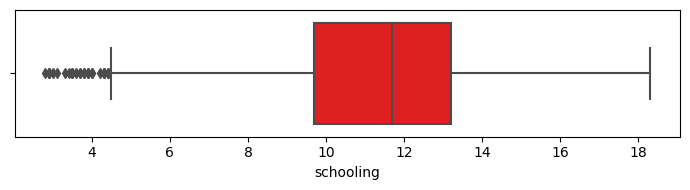

In [37]:
sns.boxplot(data=developing, x='schooling', color='red')

<AxesSubplot:xlabel='icr'>

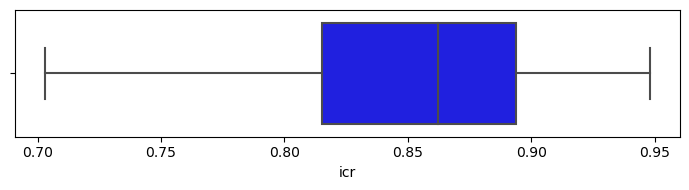

In [38]:
sns.boxplot(data=developed, x='icr', color='blue')

<AxesSubplot:xlabel='icr'>

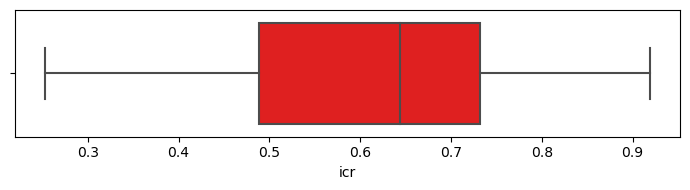

In [39]:
sns.boxplot(data=developing, x='icr', color='red')

<AxesSubplot:xlabel='bmi'>

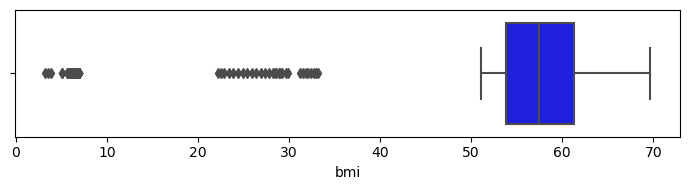

In [40]:
sns.boxplot(data=developed, x='bmi', color='blue')

<AxesSubplot:xlabel='bmi'>

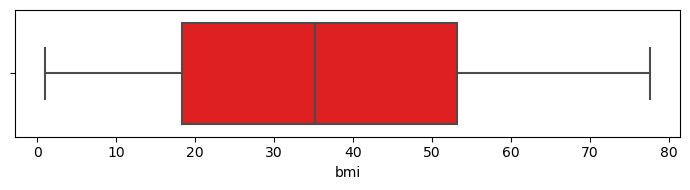

In [41]:
sns.boxplot(data=developing, x='bmi', color='red')

Based on the boxplots, the outliers for 'schooling' and 'bmi' are quite different for developed countries vs developing countries.

Imputing the missing values for developed countries: (using 8 neighbors)

In [42]:
# Creating a DataFrame of all the possible features we can use in our regression
X_developed = developed.drop(columns=['country', 'life_expectancy'])

# Standardizing the features
scaler_model = StandardScaler()
scaler_model.fit(X_developed)
developed_rescaled = scaler_model.transform(X_developed)

# Using KNN to impute missing values
knn_inputer = KNNImputer(n_neighbors=8, weights='uniform', metric='nan_euclidean')
knn_inputer.fit(developed_rescaled)
knn_inputer.transform(developed_rescaled)

# Unscaling the features that were scaled, aligning the index of the original DataFrame and columns of X
reshaped_developed = pd.DataFrame(scaler_model.inverse_transform(knn_inputer.transform(developed_rescaled)),
                                index=developed.index,
                                columns=X_developed.columns)

# Adding the 'country' and 'life_expectancy' columns back in and assigning status
reshaped_developed['country'] = developed['country']
reshaped_developed['life_expectancy'] = developed['life_expectancy']
reshaped_developed.assign(status='developed')

reshaped_developed = reshaped_developed.reindex(sorted(reshaped_developed.columns), axis=1)
reshaped_developed.isna().sum()

adult_mortality      0
alcohol              0
bmi                  0
country              0
diphtheria           0
gdp                  0
hep_b                0
hiv_aids             0
icr                  0
life_expectancy      0
per_expend           0
polio                0
schooling            0
status               0
thin_1-19_years      0
thin_5-9_years       0
total_expend         0
under-five_deaths    0
year                 0
dtype: int64

Imputing the missing values for developing countries: (using a higher number of neighbors)

In [43]:
# Creating a DataFrame of all the possible features we can use in our regression
X_developing = developing.drop(columns=['country', 'life_expectancy'])

# Standardizing the features
scaler_model = StandardScaler()
scaler_model.fit(X_developing)
developing_rescaled = scaler_model.transform(X_developing)

# Using KNN to impute missing values
knn_inputer = KNNImputer(n_neighbors=30, weights='uniform', metric='nan_euclidean')
knn_inputer.fit(developing_rescaled)
knn_inputer.transform(developing_rescaled)

# Unscaling the features that were scaled, aligning the index of the original DataFrame and columns of X
reshaped_developing = pd.DataFrame(scaler_model.inverse_transform(knn_inputer.transform(developing_rescaled)),
                                index=developing.index,
                                columns=X_developing.columns)

# Adding the 'country' and 'life_expectancy' columns back in and assigning status
reshaped_developing['country'] = developing['country']
reshaped_developing['life_expectancy'] = developing['life_expectancy']
reshaped_developing.assign(status='developing')
reshaped_developing = reshaped_developing.reindex(sorted(reshaped_developing.columns), axis=1)
reshaped_developing.isna().sum()

adult_mortality      0
alcohol              0
bmi                  0
country              0
diphtheria           0
gdp                  0
hep_b                0
hiv_aids             0
icr                  0
life_expectancy      0
per_expend           0
polio                0
schooling            0
status               0
thin_1-19_years      0
thin_5-9_years       0
total_expend         0
under-five_deaths    0
year                 0
dtype: int64

In [44]:
preprocessed_df.shape

(2928, 19)

Note: Our original preprocessed DataFrame has 2928 rows and 19 columns. After concatenating the reshaped_developed and reshaped_developing DataFrames, I want to ensure that the resulting DataFrame also has this shape.

In [45]:
all_filled = pd.concat([reshaped_developed, reshaped_developing])
all_filled.shape

(2928, 19)

In [46]:
all_filled.head()

,adult_mortality,alcohol,bmi,country,diphtheria,gdp,hep_b,hiv_aids,icr,life_expectancy,per_expend,polio,schooling,status,thin_1-19_years,thin_5-9_years,total_expend,under-five_deaths,year
112,59.0,10.21,66.6,Australia,93.0,56554.38760,93.0,0.1,0.937,82.8,10603.858678,93.0,20.4,0.0,0.6,0.6,9.30125,1.0,2015.0
113,6.0,9.71,66.1,Australia,92.0,62214.69120,91.0,0.1,0.936,82.7,10769.363050,92.0,20.4,0.0,0.6,0.6,9.42000,1.0,2014.0
114,61.0,9.87,65.5,Australia,91.0,67792.33860,91.0,0.1,0.933,82.5,11734.853810,91.0,20.3,0.0,0.6,0.6,9.36000,1.0,2013.0
115,61.0,10.03,65.0,Australia,92.0,67677.63477,91.0,0.1,0.930,82.3,11714.998580,92.0,20.1,0.0,0.6,0.6,9.36000,1.0,2012.0
116,63.0,10.30,64.4,Australia,92.0,62245.12900,92.0,0.1,0.927,82.0,10986.265270,92.0,19.8,0.0,0.6,0.6,9.20000,1.0,2011.0


## Part 3: Implementing PCA and building the linear regression model.

The correlations with all the columns to 'life_expectancy' are now much higher!

In [47]:
all_filled.corrwith(all_filled['life_expectancy']).abs().sort_values(ascending=False)

life_expectancy      1.000000
icr                  0.891189
schooling            0.792948
adult_mortality      0.696359
bmi                  0.572068
hiv_aids             0.556556
diphtheria           0.482377
status               0.482136
thin_1-19_years      0.479617
thin_5-9_years       0.473476
polio                0.468322
gdp                  0.463992
per_expend           0.426644
alcohol              0.413757
hep_b                0.344908
total_expend         0.233715
under-five_deaths    0.222529
year                 0.170033
dtype: float64

Implementing PCA...

In [48]:
X = all_filled.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]

y = np.array(all_filled.loc[:, ['life_expectancy']])

pca_model = PCA()
pca_model.fit(X)
X = pca_model.transform(X)

pd.DataFrame(X).corrwith(other=all_filled['life_expectancy']).abs().sort_values(ascending=False)

4    0.055726
0    0.051319
5    0.046869
3    0.031726
2    0.021929
1    0.011016
dtype: float64

Training the model...

In [49]:
# Defining feature and target
X = all_filled.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = np.array(all_filled.loc[:, ['life_expectancy']])

# Utilizing PCA for feature engineering
pca_model = PCA()
pca_model.fit(X)
X = pca_model.transform(X)

selected_components = [4, 0, 5, 3, 2, 1]

# Building a linear regression model 
lm_model = LinearRegression()
lm_model.fit(X[:, selected_components], y=y)
y_pred = lm_model.predict(X=X[:, selected_components])

# Calculating the residuals (actual value - predicted value)
residuals = (y - y_pred)

RMSE = residuals.std() # Root Mean Square Error
R2 = lm_model.score(X=X[:, selected_components], y=y) # coefficient of determination R^2

print('R^2:', R2, '\nRMSE:', RMSE)

R^2: 0.8732863558311253 
RMSE: 3.3896187993432263


The R squared and RMSE indicate that the model improved by a lot a good amount from the linear regression + PCA model in Section IV.

In [50]:
# Defining feature and target
X = all_filled.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = all_filled.loc[:, ['life_expectancy']]

# Splitting the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=145)

# Running a k-fold cross-validation
cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=100)
splitting = cv.split(X=X_train, y=y_train)

RMSEs = []
train_r2 = []
test_r2 = []

for train_index, test_index in splitting:
    
    X_subtraining = X_train.iloc[train_index, :].copy()
    X_subtesting = X_train.iloc[test_index, :].copy()
    
    # Utilizing PCA for feature engineering
    pca_model = PCA()
    pca_model.fit(X_subtraining)
    X_subtraining = pca_model.transform(X_subtraining)

    # Transforming the values in the subtesting dataset
    X_subtesting = pca_model.transform(X_subtesting)
    
    selected_components = [4, 0, 5, 3, 2, 1]
    
    # Building a linear regression model
    lm_model = LinearRegression()
    lm_model.fit(X=X_subtraining[:, selected_components], y=np.array(y_train.iloc[train_index]))
    y_true = np.array(y_train.iloc[test_index, :])
    y_pred = lm_model.predict(X=X_subtesting[:, selected_components])
    
    train_r2_score = lm_model.score(X=X_subtraining[:, selected_components], y=np.array(y_train.iloc[train_index]['life_expectancy']))
    test_r2_score = lm_model.score(X=X_subtesting[:, selected_components], y=y_true)
    RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    
    RMSEs.append(RMSE)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)

print(f"train_R^2: {np.mean(train_r2_scores)}\ntest_R^2: {np.mean(test_r2_scores)}\nRMSE: {np.mean(RMSEs)}")

train_R^2: 0.8384498024691622
test_R^2: 0.8357635507940097
RMSE: 3.4055134038226815


The R squared values and RMSE from the cross validation are a bit different from the results in the regression above it, but they are still an improvement from the model that was built in Section IV. 

R^2: 0.8761703249856264
RMSE: 3.3951683705355933


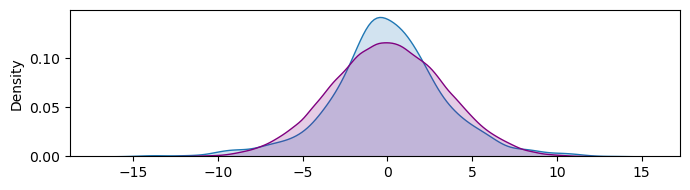

In [51]:
# Defining feature and target
X = all_filled.loc[:, ['schooling', 'icr', 'adult_mortality', 'bmi', 'hiv_aids', 'status']]
y = all_filled.loc[:, ['life_expectancy']]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=145)

# Fitting the PCA model
pca_model = PCA()
pca_model.fit(X_train)
X_train_reduced = pca_model.transform(X_train)

# Transforming the values in the test set
X_test_reduced = pca_model.transform(X_test)

selected_components = [4, 0, 5, 3, 2, 1]

lm_model = LinearRegression()
lm_model.fit(X=X_train_reduced[:, selected_components], y=np.array(y_train))
y_pred = lm_model.predict(X=X_test_reduced[:, selected_components])
y_true = np.array(y_test)

residuals = y_true - y_pred
train_r2_score = lm_model.score(X=X_train_reduced[:, selected_components], y=np.array(y_train))
test_r2_score = lm_model.score(X=X_test_reduced[:, selected_components], y=y_true)
RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

print(f"R^2: {test_r2_score}\nRMSE: {RMSE}")

plt.rcParams["figure.figsize"] = [7, 2]
plt.rcParams["figure.autolayout"] = True
sns.kdeplot(data=residuals, color='blue', fill=True, alpha=0.2, legend=False);
sns.kdeplot(x=np.random.normal(scale=RMSE, size=100000), fill=True, alpha=0.2, color='purple');

The distribution of the residuals are much closer to a normal distribution here. The R squared value and RMSE also look good, which reflects that the model has indeed improved!